## Advanced Uses of SHAP Values

### Summary Plots

Permutation importance is great because it created simple numeric measures to see which features mattered to a model. This helped us make comparisons between features easily, and you can present the resulting graphs to non-technical audiences.

But it doesn't tell you how each features matter. If a feature has medium permutation importance, that could mean it has

- a large effect for a few predictions, but no effect in general, or
- a medium effect for all predictions.

SHAP summary plots give us a birds-eye view of feature importance and what is driving it. 

You have already seen the code to load the soccer/football data:

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

data = pd.read_csv('data/FIFA-2018-Statistics.csv')
y = (data['Man of the Match'] == "Yes")  # Convert from string "Yes"/"No" to binary
feature_names = [i for i in data.columns if data[i].dtype in [np.int64, np.int64]]
X = data[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

We get the SHAP values for all validation data with the following code. It is short enough that we explain it in the comments.

In [2]:
import shap

# one row (local explanation)
row_to_show = 5
row_df = val_X.iloc[[row_to_show]]     # keep as 1-row DataFrame

# small sample for global plots (faster, cleaner)
sample = val_X.sample(min(500, len(val_X)), random_state=1)


### 1) Local explanation (single row) — waterfall + (optional) force

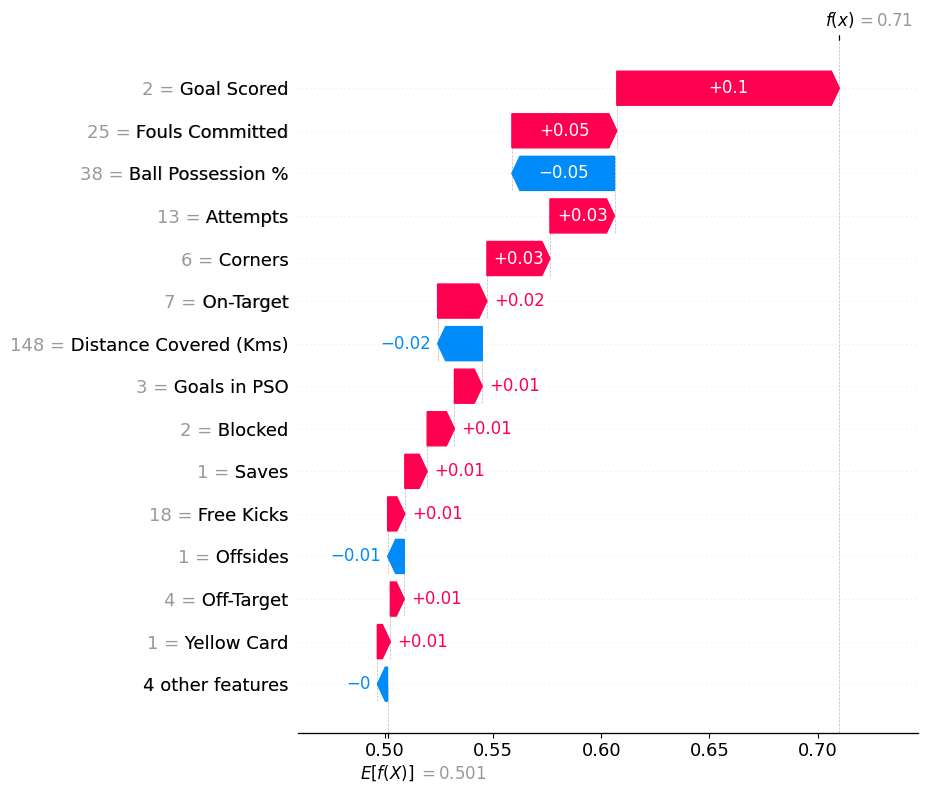

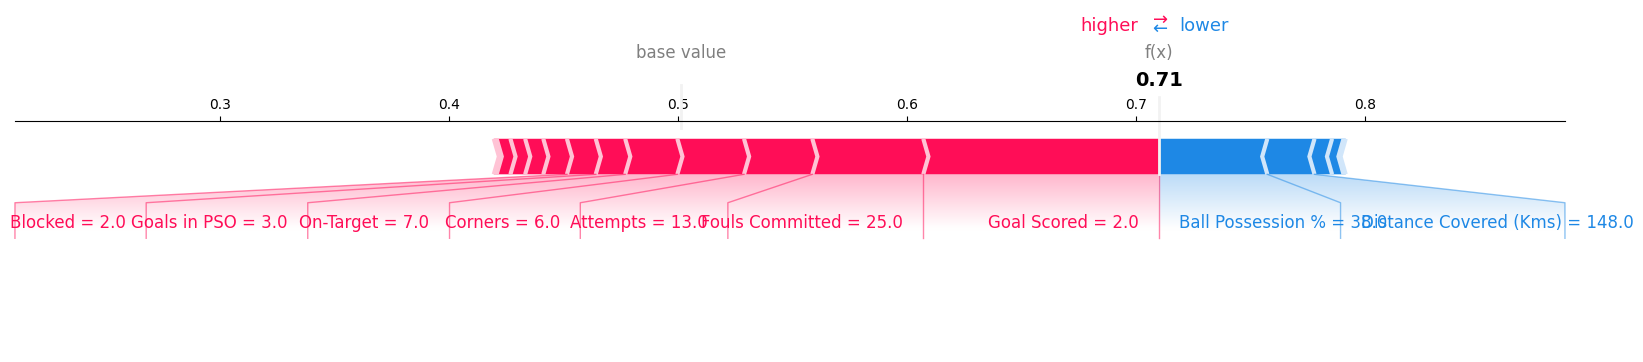

In [3]:
explainer = shap.TreeExplainer(my_model)

# Explanation for the row (robust across versions)
sv_row = explainer(row_df, check_additivity=False)   # Explanation

# If model is multiclass, select the positive class (index 1), else use as-is
try:
    sv_row_pos = sv_row[..., 1]     # take class-1 slice
except Exception:
    sv_row_pos = sv_row             # single-output

shap.initjs()

# Most reliable local viz
shap.plots.waterfall(sv_row_pos[0], max_display=15)

# Optional: force plot (matplotlib backend avoids widget issues)
base  = float(np.ravel(sv_row_pos.base_values)[0])
vals  = np.asarray(sv_row_pos.values[0], dtype=float)
feats = row_df.iloc[0]
shap.force_plot(base, vals, feats, matplotlib=True, show=True)


### 2) Global explanations — beeswarm + global bar

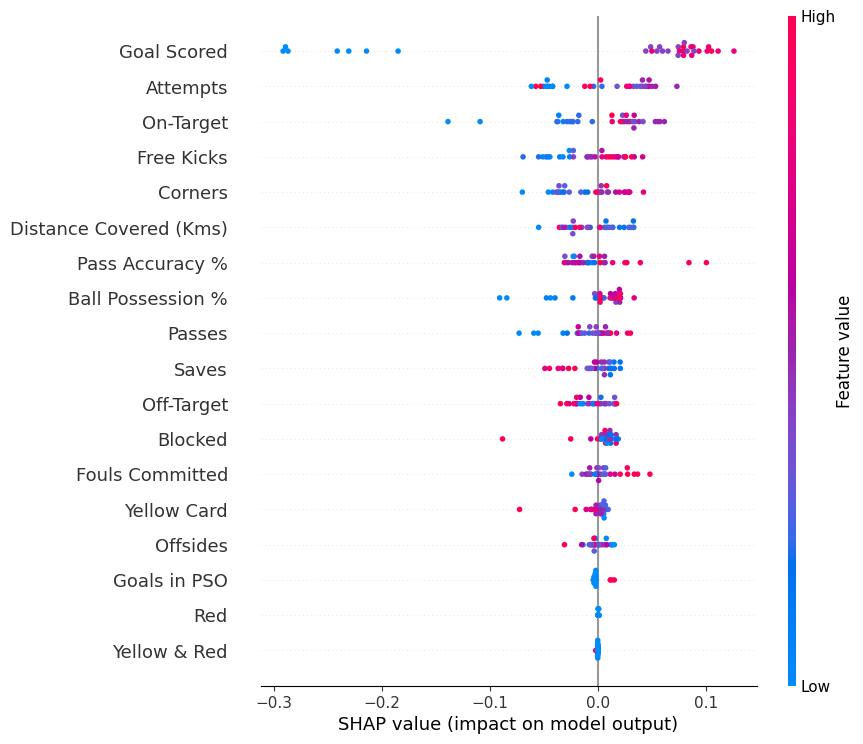

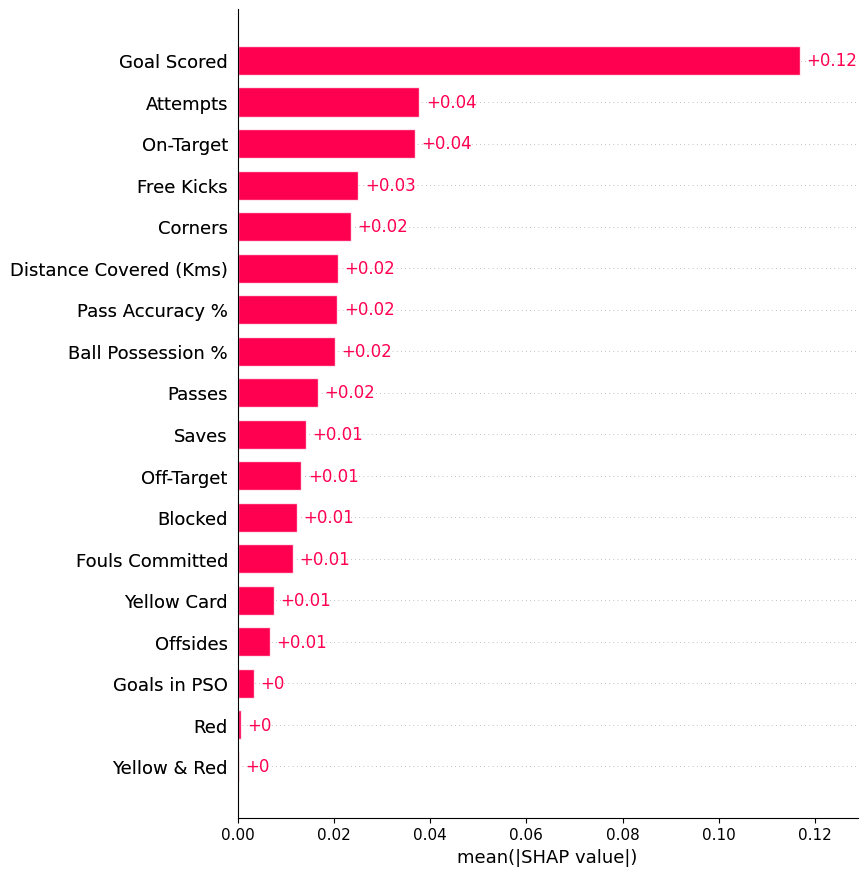

In [4]:
# Explanations for many rows
sv_many = explainer(sample, check_additivity=False)

# Select class-1 if multiclass
try:
    sv_many_pos = sv_many[..., 1]
except Exception:
    sv_many_pos = sv_many

# Global summary plots
shap.plots.beeswarm(sv_many_pos, max_display=20)
shap.plots.bar(sv_many_pos, max_display=20)

### 3) Dependence (feature effect curve) with color by another featur

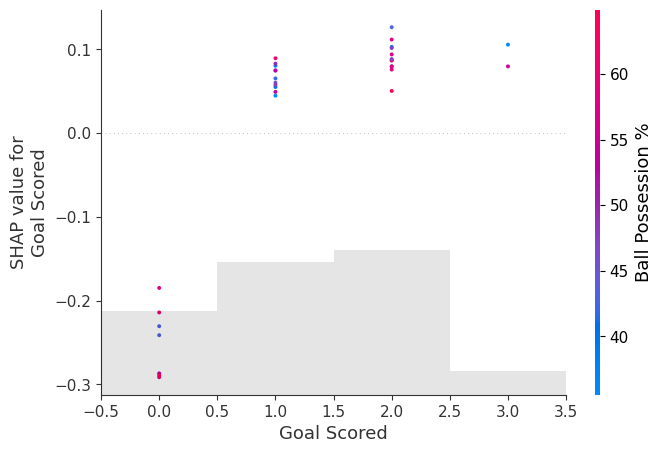

In [5]:
# Pick a main feature and a color (interaction) feature that exist in your columns
main_feat  = "Goal Scored"           # change to any column you have
color_feat = "Ball Possession %"     # change to any column you have

# Dependence / partial-ish view with interactions
shap.plots.scatter(
    sv_many_pos[:, main_feat],
    color=sv_many_pos[:, color_feat],
    dot_size=8
)

# Advanced SHAP Analysis

We applied SHAP to a `RandomForestClassifier` predicting *Man of the Match*.

## Local Explanations
For **row 5**, the model predicted a **71% probability**.  
- 🔺 Positive impact: `Goal Scored`, `Fouls Committed`, `Attempts`, `Corners`  
- 🔻 Negative impact: `Ball Possession %`, `Distance Covered (Kms)`  

**Visualizations:**
- Waterfall plot — shows how features shift the prediction from the base (~0.50) to 0.71.  
- Force plot — red features push probability higher, blue features push it lower.  

## Global Explanations
Using a sample of the validation set:
- **Beeswarm plot** highlights the most influential features across many predictions.  
- **Bar plot** ranks global feature importance.  

## Feature Dependence
Scatter plots reveal how one feature’s SHAP value changes with its magnitude, optionally colored by another feature to expose interactions.

## Interaction Effects (Optional)
Tree SHAP interaction values allow exploring how pairs of features jointly influence predictions (e.g., `Goal Scored` × `Ball Possession %`).

---

👉 **Summary:**  
SHAP confirms that **scoring goals and offensive activity** drive positive predictions for *Man of the Match*, while **possession and defensive workload** can reduce the probability.  
Both local (row-level) and global (dataset-level) insights provide a transparent interpretation of model behavior.
